In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('/kaggle/input/capstone-preprocessed/preprocessed_df_capstone.csv')
print("DF loaded")


DF loaded


In [2]:
df['self_employed'].fillna(0, inplace=True)
print(df['self_employed'].unique())

df['work_interfere'].fillna(0, inplace=True)
print(df['work_interfere'].unique())

[0. 1.]
[3. 1. 0. 2.]


/tmp/ipykernel_19/322485622.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['self_employed'].fillna(0, inplace=True)
/tmp/ipykernel_19/322485622.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [3]:
features = [
    'Age', 'Gender', 'self_employed', 'family_history', 'work_interfere',
    'no_employees', 'remote_work', 'tech_company', 'benefits',
    'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
    'mental_health_consequence', 'phys_health_consequence', 'coworkers',
    'supervisor', 'mental_health_interview', 'phys_health_interview',
    'mental_vs_physical', 'obs_consequence', 'support_score'
]

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

In [5]:
X = df[features]
y = df['treatment']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(probability=True)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained")




Logistic Regression trained
Random Forest trained
XGBoost trained
SVM trained


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, classification_report
def evaluate(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f"\n📊 {name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_prob is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

for name, model in models.items():
    evaluate(model, name)


📊 Logistic Regression Evaluation:
Accuracy: 0.8
F1 Score: 0.8015873015873016
ROC AUC: 0.8811443932411673
Confusion Matrix:
 [[ 99  25]
 [ 25 101]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       124
           1       0.80      0.80      0.80       126

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250


📊 Random Forest Evaluation:
Accuracy: 0.82
F1 Score: 0.8221343873517786
ROC AUC: 0.90520993343574
Confusion Matrix:
 [[101  23]
 [ 22 104]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82       124
           1       0.82      0.83      0.82       126

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250


📊 XGBoos

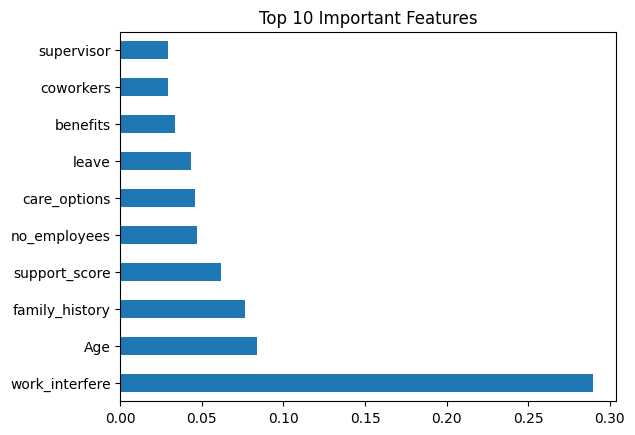

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

rf = models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

In [10]:
# Clearly we can see that Random Forest is the best performer so lets continue with it forward and fine tune it
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    "n_estimators" : [100,200,300],
    "max_depth" : [None, 10, 20, 30],
    "min_samples_split" : [2,5,10],
    "min_samples_leaf" : [1,2,4],
    "max_features" : ['sqrt','log2']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state = 42),
                      param_grid_rf,
                      scoring = 'f1',
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1
)

grid_rf.fit(X_train, y_train)
print("Best RF Params:", grid_rf.best_params_)
print("Best RF Score (F1):", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best RF Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best RF Score (F1): 0.8429587314908418


In [11]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rnd_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=param_dist,
                                n_iter=50,
                                scoring='f1',
                                cv=5,
                                n_jobs=-1,
                                verbose=1,
                                random_state=42)

rnd_search.fit(X_train, y_train)
print("Best Random Search RF Params:", rnd_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Search RF Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}


In [12]:
evaluate(best_rf, "Tuned Random Forest")
evaluate(models["Random Forest"], "Default Random Forest")
evaluate(rnd_search, "Random Search Model")


📊 Tuned Random Forest Evaluation:
Accuracy: 0.828
F1 Score: 0.8365019011406843
ROC AUC: 0.9174987199180747
Confusion Matrix:
 [[ 97  27]
 [ 16 110]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       124
           1       0.80      0.87      0.84       126

    accuracy                           0.83       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.83      0.83      0.83       250


📊 Default Random Forest Evaluation:
Accuracy: 0.82
F1 Score: 0.8221343873517786
ROC AUC: 0.90520993343574
Confusion Matrix:
 [[101  23]
 [ 22 104]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82       124
           1       0.82      0.83      0.82       126

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250


In [13]:
# after trying out different combinations.
# The best model so far is the Default Random Forest

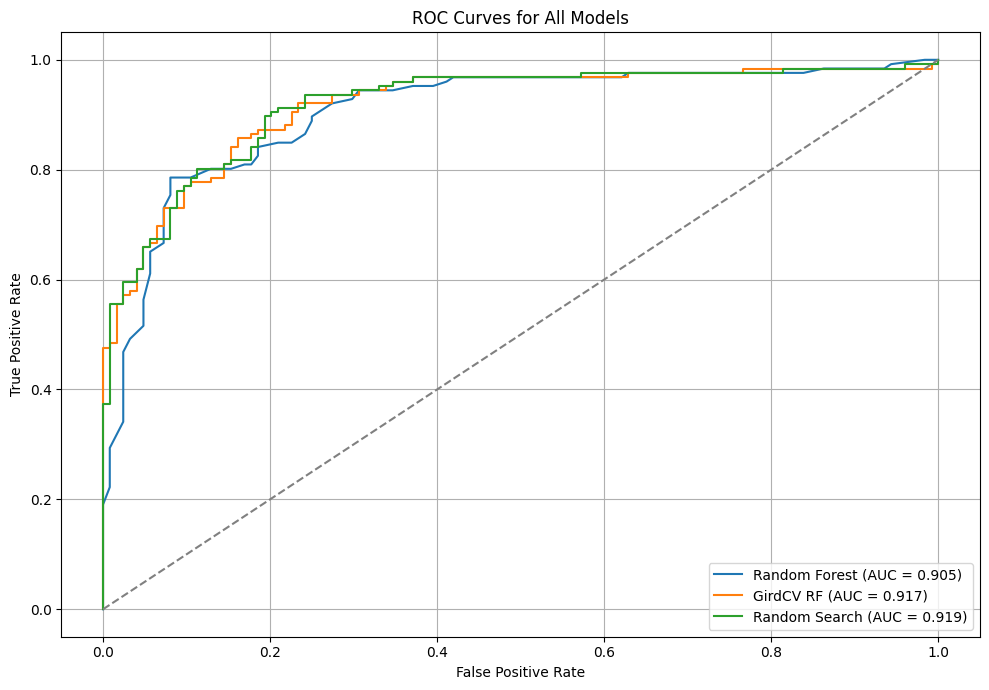

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


models = {
    'Random Forest' : models['Random Forest'],
    'GirdCV RF' : best_rf,
    'Random Search' : rnd_search,
}

plt.figure(figsize=(10, 7))

for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')


plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# This ROC plot clears things up. while the Normal RF has better accuracy 
# but the Random search RF is better at generalization.
# So are best model is the Random Search clf which attains 84% accuracy and 0.919 AUC score

In [16]:
# Let us try GridSearchCV on other algos as well for cross checking.
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                        param_grid_xgb,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

grid_xgb.fit(X_train, y_train)
print("Best XGB Params:", grid_xgb.best_params_)
print("Best XGB Score (F1):", grid_xgb.best_score_)

best_xgb = grid_xgb.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGB Params: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best XGB Score (F1): 0.8499424397983063


In [17]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000),
                       param_grid_lr,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

grid_lr.fit(X_train, y_train)
print("Best LR Params:", grid_lr.best_params_)
print("Best LR Score (F1):", grid_lr.best_score_)

best_lr = grid_lr.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best LR Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best LR Score (F1): 0.8159717245496603


In [18]:
from sklearn.svm import SVC

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(SVC(probability=True),
                        param_grid_svc,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

grid_svc.fit(X_train, y_train)
print("Best SVM Params:", grid_svc.best_params_)
print("Best SVM Score (F1):", grid_svc.best_score_)

best_svc = grid_svc.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM Score (F1): 0.8401870561279358


In [19]:
evaluate(best_rf, "Tuned Random Forest")
evaluate(best_xgb, "Tuned XGBoost")
evaluate(best_lr, "Tuned Logistic Regression")  
evaluate(best_svc, "Tuned SVM")                 


📊 Tuned Random Forest Evaluation:
Accuracy: 0.828
F1 Score: 0.8365019011406843
ROC AUC: 0.9174987199180747
Confusion Matrix:
 [[ 97  27]
 [ 16 110]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       124
           1       0.80      0.87      0.84       126

    accuracy                           0.83       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.83      0.83      0.83       250


📊 Tuned XGBoost Evaluation:
Accuracy: 0.832
F1 Score: 0.8489208633093525
ROC AUC: 0.9003136200716846
Confusion Matrix:
 [[ 90  34]
 [  8 118]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81       124
           1       0.78      0.94      0.85       126

    accuracy                           0.83       250
   macro avg       0.85      0.83      0.83       250
weighted avg       0.85      0.83      0.83       250


📊 T

In [20]:
# So now it is clear that Random Search RF is the best generalised model we can get.
# let us now save it with the whole preprocessing piepline

In [21]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class MentalHealthPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        
        drop_cols = ['Timestamp', 'state', 'Country', 'comments']
        X = X.drop(columns=[col for col in drop_cols if col in X.columns])

        
        if 'treatment' in X.columns:
            X = X.drop(columns=['treatment'])

        
        binary_map = {'Yes': 1, 'No': 0}
        binary_cols = [
            'self_employed', 'family_history', 'remote_work', 'tech_company', 
            'benefits', 'care_options', 'wellness_program', 'seek_help', 
            'anonymity', 'mental_health_consequence', 'phys_health_consequence', 
            'mental_health_interview', 'phys_health_interview', 'obs_consequence'
        ]
        for col in binary_cols:
            if col in X.columns:
                X[col] = X[col].map(binary_map).fillna(0)

        
        trinary_map = {'Yes': 2, 'No': 0, "Don't know": 1, 'Some of them': 1, 'Not sure': 1, 'Maybe': 1}
        trinary_cols = ['supervisor', 'coworkers', 'mental_vs_physical']
        for col in trinary_cols:
             if col in X.columns:
                X[col] = X[col].map(trinary_map).fillna(1)
                
        
        leave_map = {
            'Very difficult': 0, 'Somewhat difficult': 1, "Don't know": 2,
            'Somewhat easy': 3, 'Very easy': 4
        }
        if 'leave' in X.columns:
            X['leave'] = X['leave'].map(leave_map).fillna(2)

        interfere_map = {
            'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3
        }
        if 'work_interfere' in X.columns:
            X['work_interfere'] = X['work_interfere'].map(interfere_map).fillna(2)

        size_map = {
            '1-5': 0, '6-25': 1, '26-100': 2,
            '100-500': 3, '500-1000': 4, 'More than 1000': 5
        }
        if 'no_employees' in X.columns:
            X['no_employees'] = X['no_employees'].map(size_map).fillna(2)

        if 'Gender' in X.columns:
            def clean_gender(gender):
                if not isinstance(gender, str): 
                    return 'Other/Non-Binary'
                g = gender.lower()
                if 'fem' in g or 'wom' in g or g == 'f':
                    return 'Female'
                elif 'mal' in g or 'man' in g or g == 'm' or 'guy' in g:
                    return 'Male'
                else:
                    return 'Other/Non-Binary'
            
            X['Gender'] = X['Gender'].apply(clean_gender)
            le = LabelEncoder()
            X['Gender'] = le.fit_transform(X['Gender'])

        return X

In [22]:
import joblib
from sklearn.pipeline import Pipeline
final_model = rnd_search 

# Full pipeline
deployment_pipeline = Pipeline(steps=[
    ('preprocessing', MentalHealthPreprocessor()),
    ('model', final_model)
])
raw_df = pd.read_csv('/kaggle/input/mental-health-in-tech-survey/survey.csv')
filtered_df = raw_df[(raw_df['Age'] >= 18) & (raw_df['Age'] <= 65)].copy()
y_final = filtered_df['treatment'].map({'No': 0, 'Yes': 1})

deployment_pipeline.fit(filtered_df, y_final)
joblib.dump(deployment_pipeline, 'mental_health_clf_pipeline.pkl')



Fitting 5 folds for each of 50 candidates, totalling 250 fits


['mental_health_clf_pipeline.pkl']

In [23]:
pipeline = joblib.load('mental_health_clf_pipeline.pkl')

# Example input (raw row matching original dataset)
example = pd.DataFrame([{
    'Age': 28,
    'Gender': 'male',
    'self_employed': 'No',
    'family_history': 'No',
    'work_interfere': 'Often',
    'no_employees': '6-25',
    'remote_work': 'Yes',
    'tech_company': 'Yes',
    'benefits': 'Yes',
    'care_options': 'Not sure',
    'wellness_program': 'Yes',
    'seek_help': 'Yes',
    'anonymity': "Yes",
    'leave': 'Somewhat easy',
    'mental_health_consequence': 'No',
    'phys_health_consequence': 'No',
    'coworkers': 'Some of them',
    'supervisor': 'Yes',
    'mental_health_interview': 'No',
    'phys_health_interview': 'Maybe',
    'mental_vs_physical': "Don't know",
    'obs_consequence': 'No'
}])

# Predict
pred = pipeline.predict(example)
prob = pipeline.predict_proba(example)

print("Prediction:", pred[0])
print("Probability (needs treatment):", prob[0][1])

Prediction: 1
Probability (needs treatment): 0.644572189040395


In [24]:
# Pipeline is now tested